In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as plt

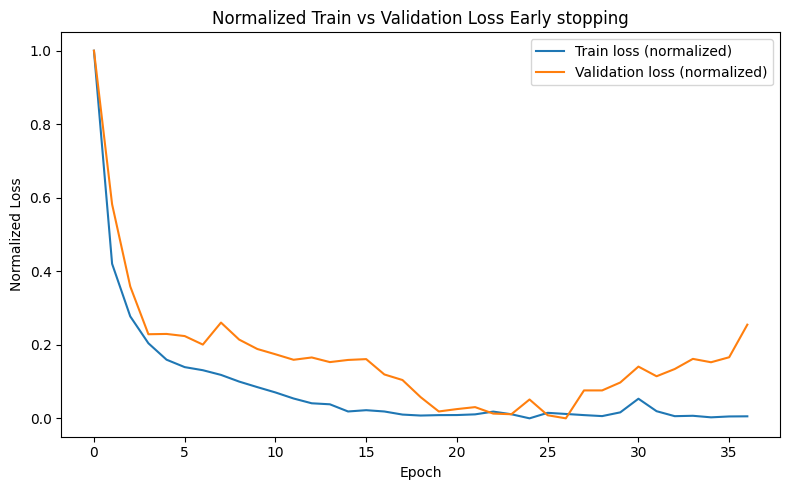

In [ ]:
df = pd.read_csv('logs/training_log.csv')

df['val_loss'] = df['val_loss'].astype(float)
df['train_loss'] = df['train_loss'].astype(float)

# Min-max normalization
train_min = df['train_loss'].min()
train_max = df['train_loss'].max()
val_min = df['val_loss'].min()
val_max = df['val_loss'].max()

df['train_loss_norm'] = (df['train_loss'] - train_min) / (train_max - train_min)
df['val_loss_norm'] = (df['val_loss'] - val_min) / (val_max - val_min)

plt.figure(figsize=(8, 5))
plt.plot(df['train_loss_norm'].values, label="Train loss (normalized)", )
plt.plot(df['val_loss_norm'].values, label="Validation loss (normalized)")
plt.title("Normalized Train vs Validation Loss Early stopping")
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x_load, x_weather_hist, x_weather_fore, y in data_loader:
            x_load = x_load.to(device)
            x_weather_hist = x_weather_hist.to(device)
            x_weather_fore = x_weather_fore.to(device)

            preds = model(x_load, x_weather_hist, x_weather_fore)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    
    y_true = np.concatenate(all_targets, axis=0)
    y_pred = np.concatenate(all_preds, axis=0)

    return y_true, y_pred

    

In [ ]:
from main import prepare_data

csv_path = 'mm79158.csv'
seq_len = 24
horizon = 12
train_loader, val_loader, test_loader, scaler = prepare_data(csv_path, seq_len, horizon, batch_size=32)
model = torch.load('models/model.pth')

Using device: cuda
Loading data...
Loaded and merged data by hourly aggregation.
Data split and scaled.
Train: 19061, Val: 2118, Test: 9077
Created 19025 sequences of length 24 with horizon 12.
Created 2082 sequences of length 24 with horizon 12.
Created 9041 sequences of length 24 with horizon 12.


C:\Users\janav\AppData\Local\Temp\ipykernel_16704\4056615054.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model.pth')


In [ ]:
import time

start_time = time.time()

y_true, y_pred = evaluate_model(model, test_loader, scaler)

end_time = time.time()
elapsed_test_time = end_time - start_time

In [55]:
import numpy as np

def expand_with_zeros_and_inverse(arr, scaler, target_col_idx=0):
    n_samples, horizon = arr.shape
    n_features = scaler.n_features_in_

    # Create dummy input for scaler
    dummy_input = np.zeros((n_samples * horizon, n_features))
    dummy_input[:, target_col_idx] = arr.flatten()

    # Inverse transform
    dummy_output = scaler.inverse_transform(dummy_input)

    # Extract just the target column and reshape
    restored = dummy_output[:, target_col_idx].reshape(n_samples, horizon)
    return restored


In [93]:
y_true = expand_with_zeros_and_inverse(y_true, scaler)
y_pred = expand_with_zeros_and_inverse(y_pred, scaler)

In [ ]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, r2_score
)
from scipy.stats import spearmanr
import numpy as np

def calculate_metrics(y_true, y_pred, elapsed_time, type='test'):
    # Flatten if needed
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # MDA - Mean Directional Accuracy
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    mda = np.mean(np.sign(y_true_diff) == np.sign(y_pred_diff))

    # Spearman correlation
    spearman_corr, _ = spearmanr(y_true, y_pred)

    return {
        'type': type,
        'inference': elapsed_time,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'MDA': mda,
        'Spearman': spearman_corr
    }



📊 Final Flattened Evaluation:
MAE:  3.5162
MSE:  24.8997
MAPE: 75.12%


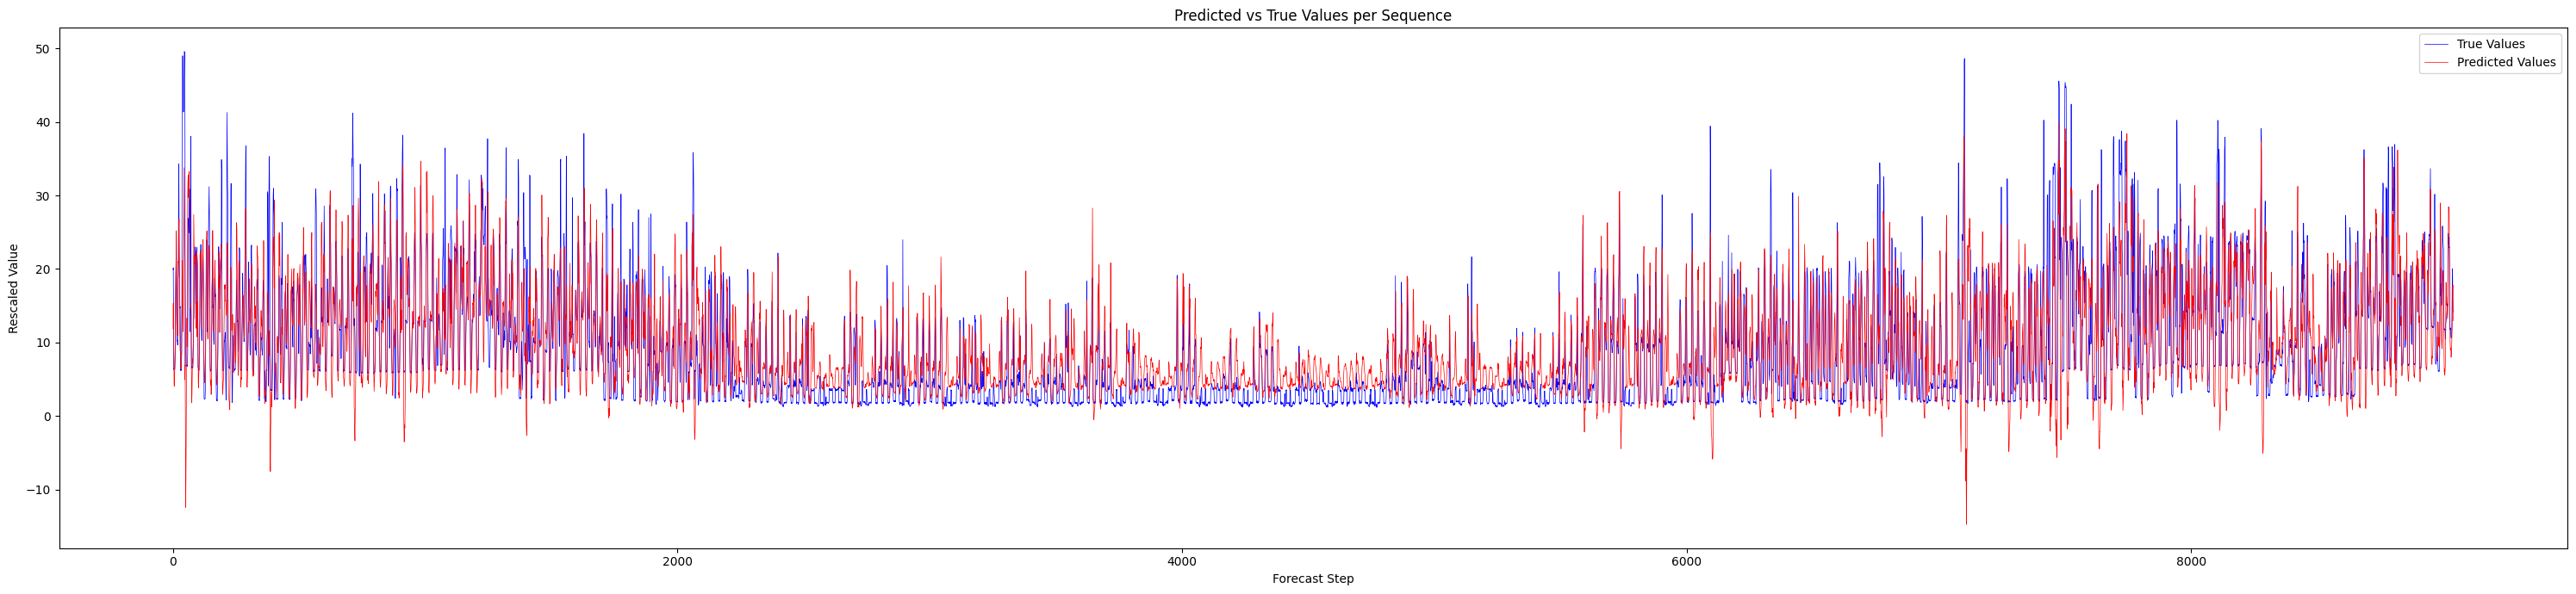

In [ ]:
y_true_flat = y_true[:, 0]
y_pred_flat = y_pred[:, 0]

results = calculate_metrics(y_true_flat, y_pred_flat, elapsed_test_time, 'st_eval')
results_df = pd.DataFrame(results)

print("\n📊 Final Flattened Evaluation:")
print(f"MAE:  {results['mae']:.4f}")
print(f"MSE:  {results['mse']:.4f}")
print(f"MAPE: {results['mape']:.2%}")

plt.figure(figsize=(30, 7))
plt.plot(y_true_flat, color='blue', linewidth=0.5, label='True Values')
plt.plot(y_pred_flat, color='red', linewidth=0.5, label='Predicted Values')
plt.title("Predicted vs True Values per Sequence")
plt.xlabel("Forecast Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()


In [86]:
import math
import numpy as np
import torch

def autoregressive_evaluation(model, val_loader, test_loader, horizon, device='cuda'):
    model.eval()
    model.to(device)

    # 1. Get last validation sample for x_load (initial sequence)
    val_last = list(val_loader)[-1]
    x_load_val, _, _, _ = val_last
    x_load = x_load_val[0].unsqueeze(0).to(device)  # shape [1, 1, T]

    # 2. Extract test data completely
    x_weather_hist_all = []
    x_weather_fore_all = []

    for x_load_test, x_weather_hist, x_weather_fore, _ in test_loader:
        x_weather_hist_all.append(x_weather_hist)
        x_weather_fore_all.append(x_weather_fore)

    x_weather_hist_all = torch.cat(x_weather_hist_all, dim=0)  # shape [N_test, T, F]
    x_weather_fore_all = torch.cat(x_weather_fore_all, dim=0)  # shape [N_test, T, F]

    total_steps = x_weather_hist_all.shape[0]  # number of test samples

    preds_all = []

    for step in range(total_steps):
        hist = x_weather_hist_all[step].unsqueeze(0).to(device)
        fore = x_weather_fore_all[step].unsqueeze(0).to(device)

        with torch.no_grad():
            preds = model(x_load, hist, fore)  # shape: [1, horizon]
        preds_all.append(preds.cpu().numpy())  # [1, horizon]

        # feed back prediction into x_load
        new_vals = preds.unsqueeze(1)  # shape [1, 1, horizon]
        x_load = torch.cat([x_load[:, :, horizon:], new_vals], dim=-1)  # shift

    # shape: [N_test, horizon]
    y_pred = np.concatenate(preds_all, axis=0)
    return y_pred


In [ ]:
import time

start_time = time.time()

y_auto = autoregressive_evaluation(model, val_loader, test_loader, horizon)

end_time = time.time()
elapsed_auto_time = end_time - start_time

y_auto = expand_with_zeros_and_inverse(y_auto, scaler)

In [79]:
y_auto.min(), y_auto.max()

(-2.3243312898610533, 28.481073577468397)


📊 Final Flattened Evaluation:
MAE:  8.8902
MSE:  120.7181
MAPE: 186.08%


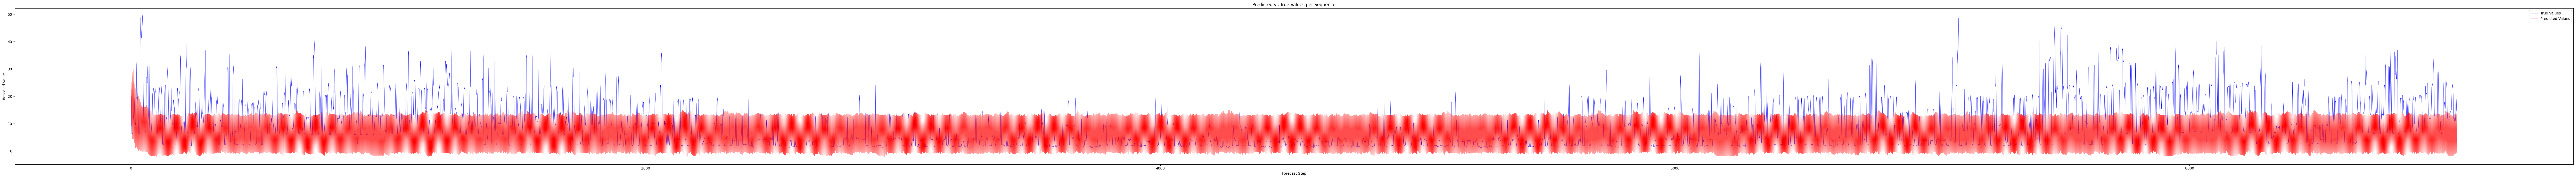

In [ ]:
y_auto_flat = y_auto[:, 0]

results_auto = calculate_metrics(y_true_flat, y_auto_flat, elapsed_auto_time, 'lt_eval')
results_df = pd.concat([results_df, pd.DataFrame(results_auto)], axis=0)  

print("\n📊 Final Flattened Evaluation:")
print(f"MAE:  {results_auto['mae']:.4f}")
print(f"MSE:  {results_auto['mse']:.4f}")
print(f"MAPE: {results_auto['mape']:.2%}")

plt.figure(figsize=(100, 7))
plt.plot(y_true_flat, color='blue', linewidth=0.5, label='True Values')
plt.plot(y_auto_flat, color='red', linewidth=0.5, label='Predicted Values')
plt.title("Predicted vs True Values per Sequence")
plt.xlabel("Forecast Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
df_preds = pd.DataFrame({
    'y_true': y_true_flat,
    'y_st': y_pred_flat,
    'y_lt': y_auto_flat
})
df_preds.to_csv('logs/prediction_data.csv', index=False)
results_df.to_csv('logs/prediction_eval.csv', index=False)